In [54]:
import os 
import sionna as sn
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras import Model
import tensorflow as tf

In [5]:
# Checking the gpu existenace

if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

tf.get_logger().setLevel("ERROR")

print("Available GPUs:", gpus)
    

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
%matplotlib inline

In [7]:
import tensorflow as tf
print(tf.__version__)

2.10.1


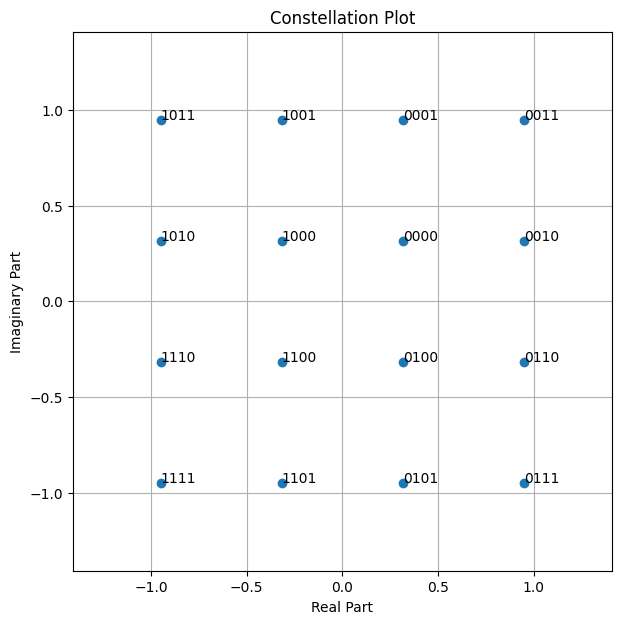

In [23]:
NUM_BITS_PER_SYMBOL = 4

constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)

constellation.show();

In [24]:
# Mapper, takes bit streams and outputs complex symbols
mapper = sn.mapping.Mapper(constellation=constellation)

# Demapper, restores the bit sequences from the symbols
demapper = sn.mapping.Demapper("app", constellation=constellation)


In [25]:
binary_source = sn.utils.BinarySource()

In [30]:
awgn_channel = sn.channel.AWGN()

In [47]:
noise = sn.utils.ebnodb2no(ebno_db=20.0,
                       num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                       coderate=1.0)
print(noise)

tf.Tensor(0.0025000002, shape=(), dtype=float32)


In [51]:
BATCH_SIZE = 64

bits = binary_source([BATCH_SIZE, 1024 * 10])

# symbols
x = mapper(bits)

# received symbols
y = awgn_channel([x, noise])

# calculating the LLRs
llr = demapper([y, noise])

(array([[ 73.,  61.,   0., 167., 223., 117., 265.,   0.,  39.,  79.],
        [ 68.,  57.,   0., 165., 210., 135., 261.,   0.,  46.,  82.],
        [ 75.,  46.,   0., 171., 233., 120., 260.,   0.,  39.,  80.],
        [ 78.,  56.,   0., 189., 215., 122., 258.,   0.,  32.,  74.],
        [ 90.,  59.,   0., 177., 193., 132., 251.,   0.,  35.,  87.],
        [ 83.,  56.,   0., 173., 185., 119., 276.,   0.,  36.,  96.],
        [ 88.,  50.,   0., 171., 192., 122., 281.,   0.,  36.,  84.],
        [ 66.,  46.,   0., 178., 213., 114., 261.,   0.,  49.,  97.],
        [ 80.,  51.,   0., 166., 204., 140., 248.,   0.,  49.,  86.],
        [ 60.,  64.,   0., 177., 214., 139., 241.,   0.,  49.,  80.],
        [ 67.,  59.,   0., 190., 221., 108., 266.,   0.,  29.,  84.],
        [ 61.,  52.,   0., 186., 217., 135., 238.,   0.,  47.,  88.],
        [ 77.,  58.,   0., 167., 186., 132., 265.,   0.,  48.,  91.],
        [ 82.,  57.,   0., 185., 201., 132., 258.,   0.,  36.,  73.],
        [ 78.,  52.,

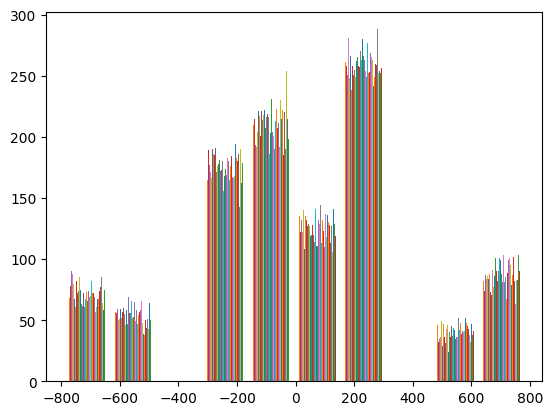

In [52]:
plt.hist(llr[0, :])

In [55]:
num_samples = 8 # how many samples shall be printed
num_symbols = int(num_samples/NUM_BITS_PER_SYMBOL)

print(f"First {num_samples} transmitted bits: {bits[0,:num_samples]}")
print(f"First {num_symbols} transmitted symbols: {np.round(x[0,:num_symbols], 2)}")
print(f"First {num_symbols} received symbols: {np.round(y[0,:num_symbols], 2)}")
print(f"First {num_samples} demapped llrs: {np.round(llr[0,:num_samples], 2)}")

First 8 transmitted bits: [1. 1. 0. 1. 0. 0. 1. 1.]
First 2 transmitted symbols: [-0.32-0.95j  0.95+0.95j]
First 2 received symbols: [-0.31-0.96j  0.96+0.93j]
First 8 demapped llrs: [ 154.33  653.08 -165.67  166.54 -653.12 -624.87  166.56  152.43]


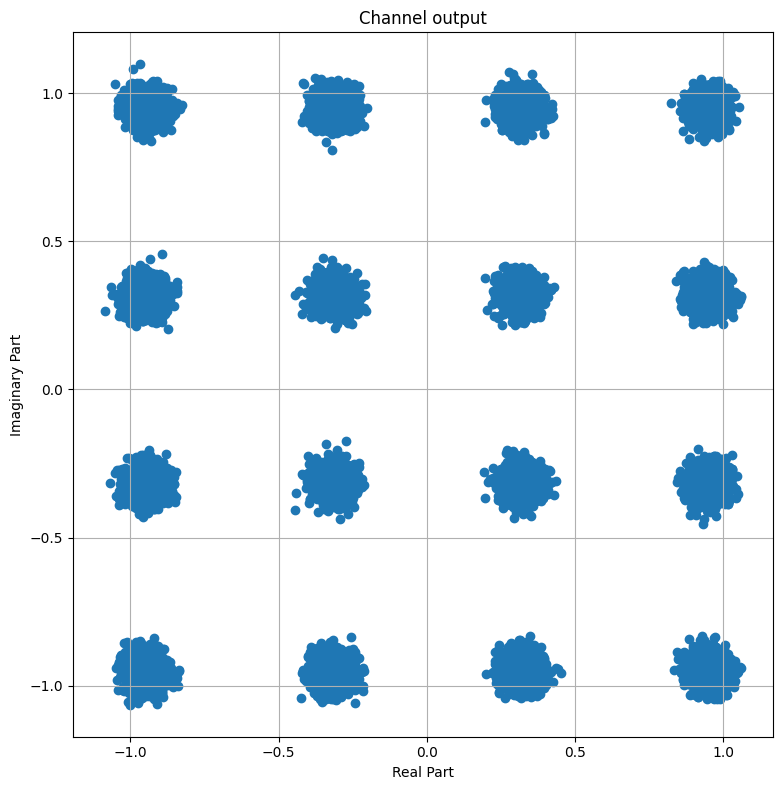

In [60]:
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()

In [61]:
class UncodedSystemAWGN(Model): # Inherits from Keras Model
    def __init__(self, num_bits_per_symbol, block_length):
        """
        A keras model of an uncoded transmission over the AWGN channel.

        Parameters
        ----------
        num_bits_per_symbol: int
            The number of bits per constellation symbol, e.g., 4 for QAM16.

        block_length: int
            The number of bits per transmitted message block (will be the codeword length later).

        Input
        -----
        batch_size: int
            The batch_size of the Monte-Carlo simulation.

        ebno_db: float
            The `Eb/No` value (=rate-adjusted SNR) in dB.

        Output
        ------
        (bits, llr):
            Tuple:

        bits: tf.float32
            A tensor of shape `[batch_size, block_length] of 0s and 1s
            containing the transmitted information bits.

        llr: tf.float32
            A tensor of shape `[batch_size, block_length] containing the
            received log-likelihood-ratio (LLR) values.
        """

        super().__init__() # Must call the Keras model initializer

        self.num_bits_per_symbol = num_bits_per_symbol
        self.block_length = block_length
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

    # @tf.function # Enable graph execution to speed things up
    def __call__(self, batch_size, ebno_db):

        # no channel coding used; we set coderate=1.0
        no = sn.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=self.num_bits_per_symbol,
                                coderate=1.0)

        bits = self.binary_source([batch_size, self.block_length]) # Blocklength set to 1024 bits
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        return bits, llr

In [62]:
model_uncoded_awgn = UncodedSystemAWGN(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, block_length=1024)


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 2.1052e-01 | 1.0000e+00 |      431145 |     2048000 |         2000 |        2000 |         0.3 |reached target block errors
   -2.579 | 2.0010e-01 | 1.0000e+00 |      409810 |     2048000 |         2000 |        2000 |         0.0 |reached target block errors
   -2.158 | 1.9084e-01 | 1.0000e+00 |      390844 |     2048000 |         2000 |        2000 |         0.0 |reached target block errors
   -1.737 | 1.8012e-01 | 1.0000e+00 |      368891 |     2048000 |         2000 |        2000 |         0.0 |reached target block errors
   -1.316 | 1.7084e-01 | 1.0000e+00 |      349886 |     2048000 |         2000 |        2000 |         0.0 |reached target block errors
   -0.895 | 1.6119e-01 | 1.0000e+00 |      330125 |     2048000 |

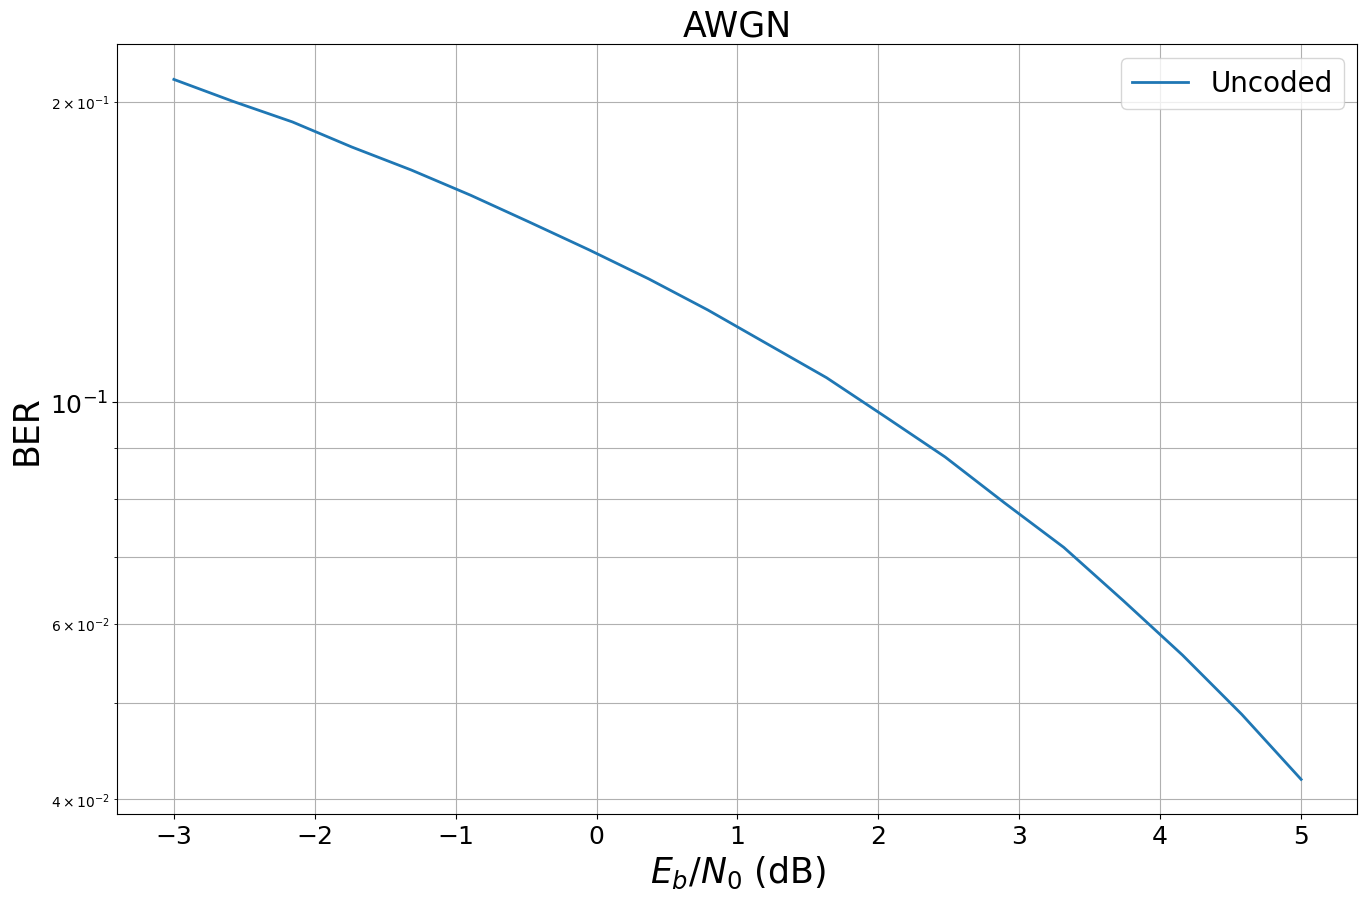

In [63]:
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 5.0 # Maximum value of Eb/N0 [dB] for simulations
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel

ber_plots = sn.utils.PlotBER("AWGN")
ber_plots.simulate(model_uncoded_awgn,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Uncoded",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=True);

In [64]:
k = 12
n = 20

encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)
decoder = sn.fec.ldpc.LDPC5GDecoder(encoder, hard_out=True)

In [65]:
BATCH_SIZE = 1 # one codeword in parallel
u = binary_source([BATCH_SIZE, k])
print("Input bits are: \n", u.numpy())

c = encoder(u)
print("Encoded bits are: \n", c.numpy())

Input bits are: 
 [[1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.]]
Encoded bits are: 
 [[0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1.]]


In [66]:
BATCH_SIZE = 10 # samples per scenario
num_basestations = 4
num_users = 5 # users per basestation
n = 1000 # codeword length per transmitted codeword
coderate = 0.5 # coderate

k = int(coderate * n) # number of info bits per codeword

# instantiate a new encoder for codewords of length n
encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# the decoder must be linked to the encoder (to know the exact code parameters used for encoding)
decoder = sn.fec.ldpc.LDPC5GDecoder(encoder,
                                    hard_out=True, # binary output or provide soft-estimates
                                    return_infobits=True, # or also return (decoded) parity bits
                                    num_iter=20, # number of decoding iterations
                                    cn_type="boxplus-phi") # also try "minsum" decoding

# draw random bits to encode
u = binary_source([BATCH_SIZE, num_basestations, num_users, k])
print("Shape of u: ", u.shape)

# We can immediately encode u for all users, basetation and samples
# This all happens with a single line of code
c = encoder(u)
print("Shape of c: ", c.shape)

print("Total number of processed bits: ", np.prod(c.shape))

Shape of u:  (10, 4, 5, 500)
Shape of c:  (10, 4, 5, 1000)
Total number of processed bits:  200000


In [67]:
k = 64
n = 128

encoder = sn.fec.polar.Polar5GEncoder(k, n)
decoder = sn.fec.polar.Polar5GDecoder(encoder,
                                      dec_type="SCL") # you can also use "SCL"

In [68]:
class CodedSystemAWGN(Model): # Inherits from Keras Model
    def __init__(self, num_bits_per_symbol, n, coderate):
        super().__init__() # Must call the Keras model initializer

        self.num_bits_per_symbol = num_bits_per_symbol
        self.n = n
        self.k = int(n*coderate)
        self.coderate = coderate
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)

        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)

        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

        self.encoder = sn.fec.ldpc.LDPC5GEncoder(self.k, self.n)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

    #@tf.function # activate graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=self.coderate)

        bits = self.binary_source([batch_size, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        bits_hat = self.decoder(llr)
        return bits, bits_hat

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 3.2151e-01 | 1.0000e+00 |      658449 |     2048000 |         2000 |        2000 |         1.8 |reached target block errors
   -2.429 | 3.0866e-01 | 1.0000e+00 |      632145 |     2048000 |         2000 |        2000 |         1.5 |reached target block errors
   -1.857 | 2.9679e-01 | 1.0000e+00 |      607821 |     2048000 |         2000 |        2000 |         1.4 |reached target block errors
   -1.286 | 2.8250e-01 | 1.0000e+00 |      578566 |     2048000 |         2000 |        2000 |         1.4 |reached target block errors
   -0.714 | 2.6768e-01 | 1.0000e+00 |      548215 |     2048000 |         2000 |        2000 |         1.4 |reached target block errors
   -0.143 | 2.5263e-01 | 1.0000e+00 |      517387 |     2048000 |

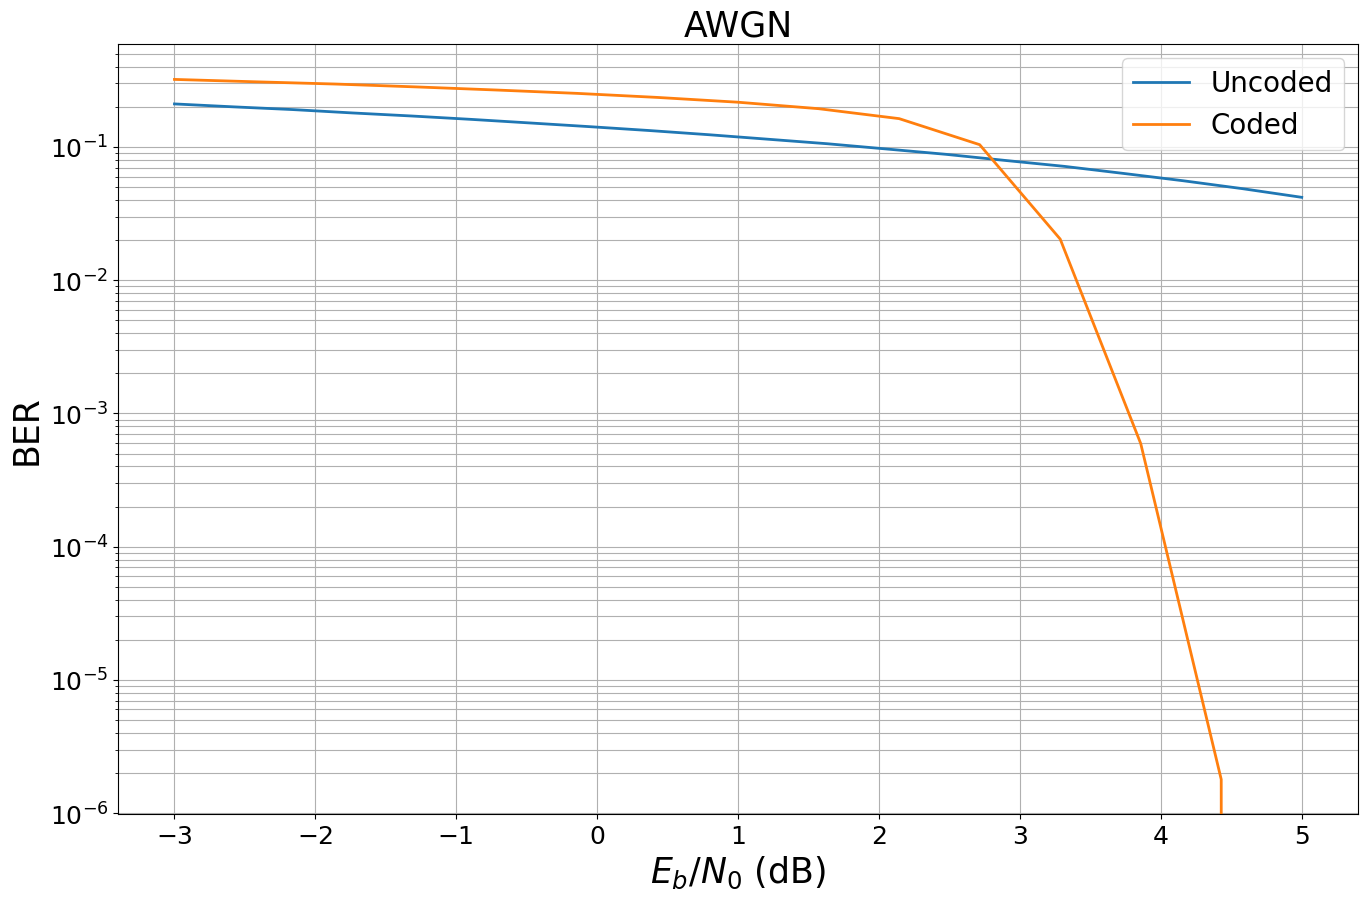

In [69]:
CODERATE = 0.5
BATCH_SIZE = 2000

model_coded_awgn = CodedSystemAWGN(num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                   n=2048,
                                   coderate=CODERATE)
ber_plots.simulate(model_coded_awgn,
                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 15),
                   batch_size=BATCH_SIZE,
                   num_target_block_errors=500,
                   legend="Coded",
                   soft_estimates=False,
                   max_mc_iter=15,
                   show_fig=True,
                   forward_keyboard_interrupt=False);

In [70]:
@tf.function() # enables graph-mode of the following function
def run_graph(batch_size, ebno_db):
    # all code inside this function will be executed in graph mode, also calls of other functions
    print(f"Tracing run_graph for values batch_size={batch_size} and ebno_db={ebno_db}.") # print whenever this function is traced
    return model_coded_awgn(batch_size, ebno_db)

In [75]:
batch_size = 10 # try also different batch sizes
ebno_db = 1.5

# run twice - how does the output change?
run_graph(batch_size, ebno_db)

(<tf.Tensor: shape=(10, 1024), dtype=float32, numpy=
 array([[1., 1., 1., ..., 0., 1., 1.],
        [1., 0., 1., ..., 1., 0., 1.],
        [0., 1., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1024), dtype=float32, numpy=
 array([[1., 1., 1., ..., 0., 1., 1.],
        [1., 0., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 0., ..., 1., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 1., 1.]], dtype=float32)>)

In [72]:
print(run_graph.pretty_printed_concrete_signatures())


run_graph(batch_size=10, ebno_db=1.5)
  Returns:
    (<1>, <2>)
      <1>: float32 Tensor, shape=(10, 1024)
      <2>: float32 Tensor, shape=(10, 1024)


In [76]:
repetitions = 4 # average over multiple runs
batch_size = BATCH_SIZE # try also different batch sizes
ebno_db = 1.5

# --- eager mode ---
t_start = time.perf_counter()
for _ in range(repetitions):
    bits, bits_hat = model_coded_awgn(tf.constant(batch_size, tf.int32),
                                tf.constant(ebno_db, tf. float32))
t_stop = time.perf_counter()
# throughput in bit/s
throughput_eager = np.size(bits.numpy())*repetitions / (t_stop - t_start) / 1e6

print(f"Throughput in Eager mode: {throughput_eager :.3f} Mbit/s")
# --- graph mode ---
# run once to trace graph (ignored for throughput)
run_graph(tf.constant(batch_size, tf.int32),
          tf.constant(ebno_db, tf. float32))

t_start = time.perf_counter()
for _ in range(repetitions):
    bits, bits_hat = run_graph(tf.constant(batch_size, tf.int32),
                                tf.constant(ebno_db, tf. float32))
t_stop = time.perf_counter()
# throughput in bit/s
throughput_graph = np.size(bits.numpy())*repetitions / (t_stop - t_start) / 1e6

print(f"Throughput in graph mode: {throughput_graph :.3f} Mbit/s")

Throughput in Eager mode: 1.455 Mbit/s
Tracing run_graph for values batch_size=Tensor("batch_size:0", shape=(), dtype=int32) and ebno_db=Tensor("ebno_db:0", shape=(), dtype=float32).
Throughput in graph mode: 3.398 Mbit/s


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 3.2201e-01 | 1.0000e+00 |      659475 |     2048000 |         2000 |        2000 |         0.9 |reached target block errors
   -2.273 | 3.0484e-01 | 1.0000e+00 |      624319 |     2048000 |         2000 |        2000 |         0.6 |reached target block errors
   -1.545 | 2.8856e-01 | 1.0000e+00 |      590973 |     2048000 |         2000 |        2000 |         0.6 |reached target block errors
   -0.818 | 2.7095e-01 | 1.0000e+00 |      554903 |     2048000 |         2000 |        2000 |         0.6 |reached target block errors
   -0.091 | 2.5132e-01 | 1.0000e+00 |      514695 |     2048000 |         2000 |        2000 |         0.6 |reached target block errors
    0.636 | 2.2890e-01 | 1.0000e+00 |      468784 |     2048000 |

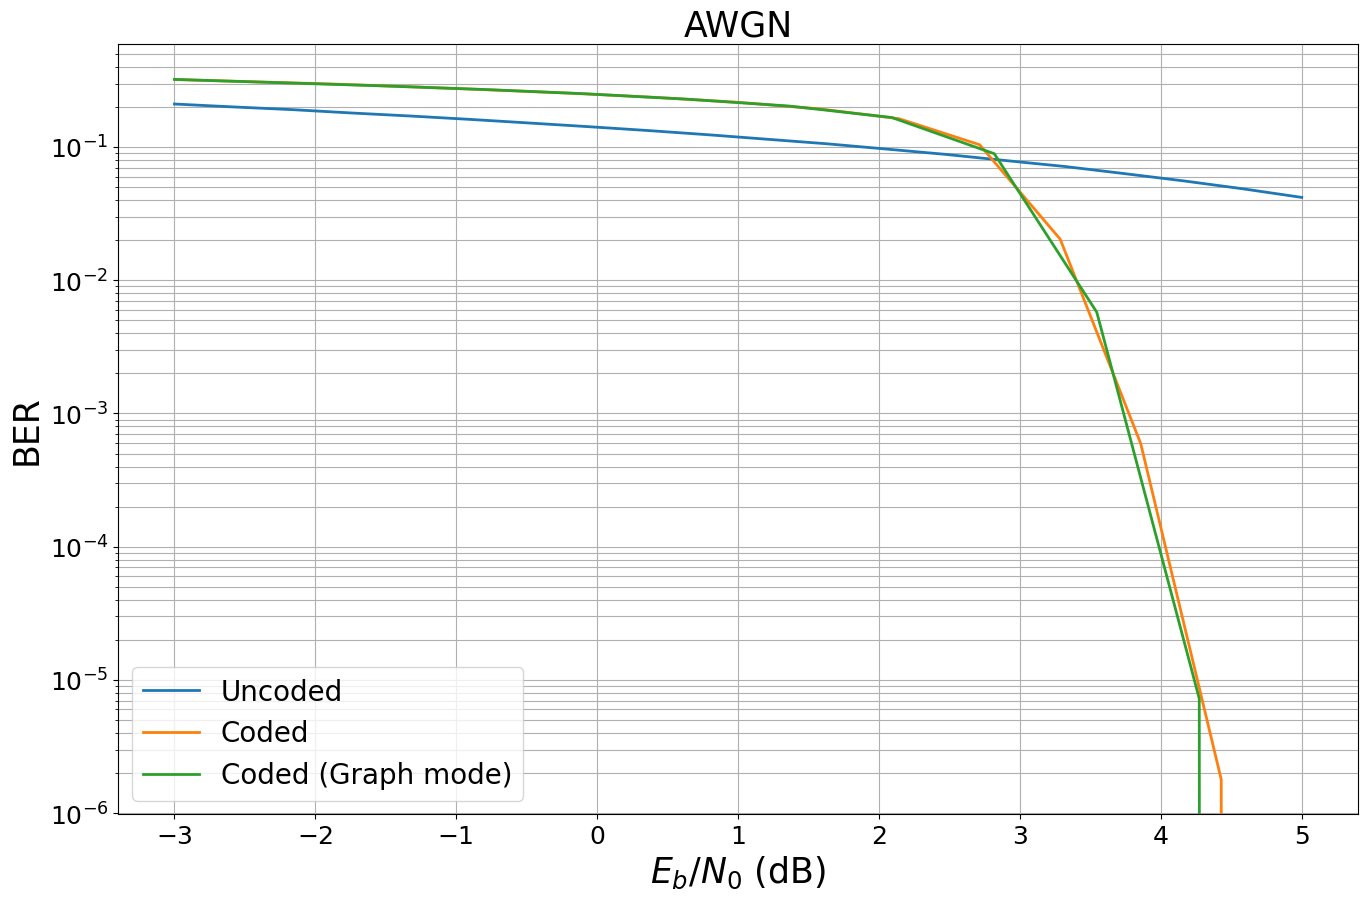

In [77]:
ber_plots.simulate(run_graph,
                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 12),
                   batch_size=BATCH_SIZE,
                   num_target_block_errors=100,
                   legend="Coded (Graph mode)",
                   soft_estimates=True,
                   max_mc_iter=100,
                   show_fig=True,
                   forward_keyboard_interrupt=False);